In [1]:
import os
import random
from tqdm import tqdm
from joblib import Parallel,delayed
import pickle
import numpy as np
import gc
import cv2
import itertools
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import scipy
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
_=torch.manual_seed(manualSeed)

Random Seed:  999


#  Data Loading

In [2]:
DATA_DIR = '../video_data/face_images_features_every_n_second/'
AUDIO_FEATURES_DIR = '../audio_features/audio_features/'

time_delay = 50
look_back = 100

audio_frames_per_seconds = 200
video_frames_per_seconds = 20

In [3]:
data_files = os.listdir(DATA_DIR)
audio_features_files = os.listdir(AUDIO_FEATURES_DIR)
files = sorted(list(set(data_files).intersection(set(audio_features_files))))
files = [fn for fn in files if 'pickle' in fn]
files.sort()
len(files)

79

In [4]:
def _load_single(fn, subsample_one_every_n):
    X_audio, X_video, X_face_features = [], [], []
    
    with open(os.path.join(AUDIO_FEATURES_DIR,fn), 'rb') as f:
        audio = pickle.load(f)
    
    with open(os.path.join(DATA_DIR,fn), 'rb') as f:
        video, face_features = pickle.load(f)
    
    for i_start in range(0, len(audio), subsample_one_every_n):
        i_end = i_start + look_back

        if i_end > len(audio):
            continue

        i_video = int(((i_start + look_back - time_delay) / audio_frames_per_seconds) * video_frames_per_seconds)

        if i_video < 0 or i_video >= len(video):
            continue

        a = audio[i_start:i_end]
        v = video[i_video]
        ff = face_features[i_video]
        
        if np.any(v.std(axis=0)==0):
            continue
        if np.any(ff.std(axis=0)==0):
            continue
        if np.any(a.std(axis=0)==0):
            continue
        X_audio.append(a)
        X_video.append(v)
        X_face_features.append(ff)
    del video, face_features, audio
    gc.collect()
    return X_audio, X_video, X_face_features

In [5]:
def load_multiple(fns, subsample_one_every_n, with_audio=True):
    def _concatenate(iterables_arr):
        return np.array(list(itertools.chain(*iterables_arr)), dtype=np.float64)
    
    with tqdm(fns) as tqdm_fns:
        with Parallel(n_jobs=-1) as par:
            res = par(delayed(_load_single)(fn, subsample_one_every_n) for fn in tqdm_fns)
    
    X_audio, X_video, X_face_features = [], [], []
    
    for X_audio1, X_video1, X_face_features1 in res:
        if with_audio:
            X_audio.append(X_audio1)
        X_video.append(X_video1)
        X_face_features.append(X_face_features1)
    
    gc.collect()
    X_audio, y, X_face_features = map(_concatenate, [X_audio, X_video, X_face_features])
    X_video = np.array(y)
    X_video[:, 67:87, 16:-16, :] = -1

    gc.collect()
    if with_audio:
        return X_audio, X_video, X_face_features, y
    else:
        return X_video, X_face_features, y

In [226]:
trainX_video, trainX_face_features, trainy = load_multiple(files[10:20], 20, False)

100%|██████████| 10/10 [00:00<00:00, 13.57it/s]


In [227]:
def print_shape(X_video, X_face_features, y, name):
    print(name)
    print('\tX_video\t\t', X_video.shape)
    print('\tX_face_features\t', X_face_features.shape)
    print('\ty\t\t', y.shape)
print_shape(trainX_video, trainX_face_features, trainy,'train')

train
	X_video		 (12423, 100, 74, 3)
	X_face_features	 (12423, 68, 2)
	y		 (12423, 100, 74, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


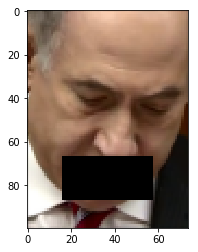

In [228]:
plt.imshow(trainX_video[26])

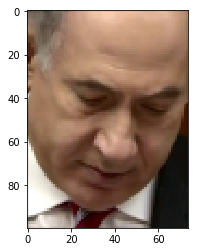

In [229]:
plt.imshow(trainy[26])

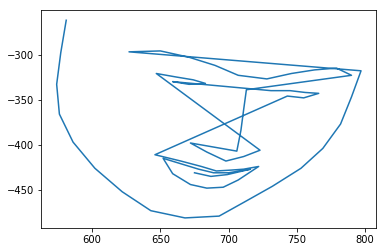

In [230]:
plt.plot(trainX_face_features[26,:,0],-trainX_face_features[26,:,1])

# Normalize Data

In [231]:
trainX_face_features_x = trainX_face_features[:,:,0]
trainX_face_features_y = trainX_face_features[:,:,1]

trainX_face_features_x -= trainX_face_features_x.min(axis=1, keepdims=True)
trainX_face_features_x /= trainX_face_features_x.max(axis=1, keepdims=True)

trainX_face_features_y -= trainX_face_features_y.min(axis=1, keepdims=True)
trainX_face_features_y /= trainX_face_features_y.max(axis=1, keepdims=True)

trainX_face_features[:,:,0] = trainX_face_features_x
trainX_face_features[:,:,1] = trainX_face_features_y

In [232]:
print(trainX_face_features[:,:,0].max(axis=1))
print(trainX_face_features[:,:,1].max(axis=1))
print(trainX_face_features[:,:,0].min(axis=1))
print(trainX_face_features[:,:,1].min(axis=1))

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [233]:
trainX_face_features = trainX_face_features.reshape(
    (trainX_face_features.shape[0],-1))

In [234]:
trainX_face_features.shape

(12423, 136)

In [15]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

In [235]:
trainX_video = torch.Tensor(trainX_video)
trainX_face_features = torch.Tensor(trainX_face_features)
trainy = torch.Tensor(trainy)

In [236]:
trainX_video = trainX_video.permute([0,3,1,2])
trainy = trainy.permute([0,3,1,2])

In [237]:
trainX_video = trainX_video.to(device)
trainX_face_features = trainX_face_features.to(device)
trainy = trainy.to(device)

# Define Generator

In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)        

In [93]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.leakyReLU = nn.LeakyReLU(0.2, inplace=False)
        self.conv1 = nn.Conv2d(3, 6, 4, 2, (1,0))
        self.conv2 = nn.Conv2d(6, 12, 4, 2, (0,1))
        self.batchnorm1 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 12, 4, 2, (1,0))
        self.batchnorm2 = nn.BatchNorm2d(12)
        self.conv4 = nn.Conv2d(12, 12, 4, 2, 1)
        self.batchnorm3 = nn.BatchNorm2d(12)
        self.linear1 = nn.Linear(288, 30)
        self.linear2 = nn.Linear(30, 60)
        
        self.linear1_ff = nn.Linear(136, 40)
        self.linear2_ff = nn.Linear(40, 10)
        
        self.up_linear1 = nn.Linear(70, 30)
        self.up_linear2 = nn.Linear(30, 288)
        
        self.up_stage_0 = nn.Conv2d(24, 3, 3, 1, 1)

        self.up_convt1 = nn.ConvTranspose2d(24,12,4,2,1)
        self.up_batchnorm1 = nn.BatchNorm2d(12)
        self.up_stage_1 = nn.Conv2d(24, 3, 3, 1, 1)

        self.up_convt2 = nn.ConvTranspose2d(24,12,4,2,(1,0))
        self.up_batchnorm2 = nn.BatchNorm2d(12)
        self.up_stage_2 = nn.Conv2d(24, 3, 3, 1, 1)

        self.up_convt3 = nn.ConvTranspose2d(24,6,4,2,(0,1))
        self.up_batchnorm3 = nn.BatchNorm2d(6)
        self.up_stage_3 = nn.Conv2d(12, 3, 3, 1, 1)

        self.up_convt4 = nn.ConvTranspose2d(12,3,4,2,(1,0))
        self.up_batchnorm4 = nn.BatchNorm2d(3)
        
        self.res_conv1 = nn.Conv2d(3,10,5,1,2)
        self.res_conv2 = nn.Conv2d(10,3,5,1,2)
        self.res_conv3 = nn.Conv2d(6,3,5,1,2)
        
        self.sigmoid = nn.Sigmoid()
        
        self.upsample = nn.Upsample((100,74))
        
    def forward(self, original_image, face_features, return_stage=-1):
        y = self.leakyReLU(self.linear1_ff(face_features))
        y = self.leakyReLU(self.linear2_ff(y))
        
        x_down_1 =original_image.clone()
        x_down_1[original_image==-1]=0
        
        x_down_2 = self.leakyReLU(self.conv1(x_down_1))

        x_down_3 = self.conv2(x_down_2)
        x_down_3 = self.leakyReLU(self.batchnorm1(x_down_3))

        x_down_4 = self.conv3(x_down_3)
        x_down_4 = self.leakyReLU(self.batchnorm2(x_down_4))

        x_down_5 = self.conv4(x_down_4)
        x_down_5 = self.leakyReLU(self.batchnorm3(x_down_5))

        x = x_down_5.reshape((-1,288))
        
        x = self.leakyReLU(self.linear1(x))
        x = self.leakyReLU(self.linear2(x))

        x = torch.cat((x,y), dim=1)
        
        x = self.leakyReLU(self.up_linear1(x))
        x = self.leakyReLU(self.up_linear2(x))
        
        x = x.reshape((-1, 12, 6, 4))
        
        x = torch.cat((x,x_down_5), dim=1)
        x0 = self.upsample(self.sigmoid(self.up_stage_0(x)))
        
        x = self.leakyReLU(self.up_batchnorm1(self.up_convt1(x)))
        x = torch.cat((x,x_down_4), dim=1)
        x1 = self.upsample(self.sigmoid(self.up_stage_1(x)))
        
        x = self.leakyReLU(self.up_batchnorm2(self.up_convt2(x)))
        x = torch.cat((x,x_down_3), dim=1)
        x2 = self.upsample(self.sigmoid(self.up_stage_2(x)))
        
        x = self.leakyReLU(self.up_batchnorm3(self.up_convt3(x)))
        x = torch.cat((x,x_down_2), dim=1)
        x3 = self.upsample(self.sigmoid(self.up_stage_3(x)))
        
        x = self.sigmoid(self.up_batchnorm4(self.up_convt4(x)))
        x4 = x
        
        x = x.clone()
        x[original_image!=-1] = original_image[original_image!=-1]
        
        x_start = x.clone()
        x = self.leakyReLU(self.res_conv1(x))
        x = self.leakyReLU(self.res_conv2(x))
        x = torch.cat((x,x_start),dim=1)
        x = torch.sigmoid(self.res_conv3(x)).clone()
        mask = original_image!=-1
        x[mask] = original_image[mask]
        x5 = x
        
        return x0, x1, x2, x3, x4, x5

generator = Generator()
generator.apply(weights_init)
generator = generator.to(device)

for i,output in enumerate(generator.forward(
    trainX_video[:100],
    trainX_face_features[:100])):
    print(i,output.detach().cpu().numpy().shape)
print(generator)

0 (100, 3, 100, 74)
1 (100, 3, 100, 74)
2 (100, 3, 100, 74)
3 (100, 3, 100, 74)
4 (100, 3, 100, 74)
5 (100, 3, 100, 74)
Generator(
  (leakyReLU): LeakyReLU(negative_slope=0.2)
  (conv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 0))
  (conv2): Conv2d(6, 12, kernel_size=(4, 4), stride=(2, 2), padding=(0, 1))
  (batchnorm1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 0))
  (batchnorm2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(12, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=288, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=60, bias=True)
  (linear1_ff): Linear(in_features=136, out_features=40, bias=True)
  (linear2_ff): Linear(in_features

In [238]:
def get_error(X,X_FF,Y,weights,batch,criterion):
    res = []
    output = generator.forward(
            X[batch],
            X_FF[batch])
    for stage in range(6):
        g_err = criterion(output[stage], Y[batch])
        g_err *= weights[stage]
        res.append(g_err)
    return sum(res)

# First Training Stages - L1 training

In [239]:
def train_stage(weights, epochs, batch_size, lr, print_every=3):
    criterion = nn.L1Loss(reduction='mean')
    optimizerG = optim.RMSprop(generator.parameters(), lr=lr)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    for epoch in range(epochs):
        perm = np.arange(trainy.shape[0])
        random.shuffle(perm)
        with tqdm(range(batch_size, len(perm)+1, batch_size), desc="batchs") as _tqdm:
            for i in _tqdm:
                batch = perm[i-batch_size:i]

                g_err = get_error(
                    trainX_video,
                    trainX_face_features,
                    trainy,
                    weights,
                    batch,
                    criterion
                )
                g_err.backward()
                optimizerG.step()

            if epoch%print_every==0:
                test_sample = random.sample(range(trainy.shape[0]),100)
                g_err = get_error(
                    trainX_video,
                    trainX_face_features,
                    trainy,
                    weights,
                    test_sample,
                    criterion
                )
                print(g_err.item())
    gc.collect()
    torch.cuda.empty_cache()

In [241]:
gc.collect()
torch.cuda.empty_cache()

# Predicting The Mean\Median

In [24]:
((trainy-trainy.median(dim=0).values.unsqueeze(0))**2).mean()

tensor(0.0313, device='cuda:0')

In [25]:
((trainy-trainy.mean(dim=0).unsqueeze(0))**2).mean()

tensor(0.0297, device='cuda:0')

# Train Phase 1 - Equal value for all resolutions

In [104]:
train_stage(weights={0:1/6, 1:1/6, 2:1/6, 3:1/6, 4:1/6, 5:1/6},
            epochs=20, 
            batch_size=32, 
            lr=0.000001,
            print_every=1)

batchs:   1%|          | 3/315 [00:00<00:11, 26.41it/s]

0.022586962208151817


batchs:   1%|          | 3/315 [00:00<00:11, 26.34it/s]

0.02233041264116764


batchs:   1%|          | 3/315 [00:00<00:11, 26.40it/s]

0.022326011210680008


batchs:   1%|          | 3/315 [00:00<00:11, 26.29it/s]

0.022990571334958076


batchs:  47%|████▋     | 147/315 [00:05<00:06, 26.06it/s]


KeyboardInterrupt: 

# Train Phase 2

In [183]:
train_stage(weights={0:1/36, 1:2/36, 2:3/36, 3:6/36, 4:8/36, 5:16/36},
            epochs=2,
            batch_size=32, 
            lr=0.00001,
            print_every=1)

batchs:  95%|█████████▌| 300/315 [00:11<00:00, 25.96it/s]


KeyboardInterrupt: 

# Train Phase 3

In [189]:
train_stage(weights={0:0.5/36, 1:1/36, 2:1.5/36, 3:2/36, 4:3/36, 5:(36-(0.5+1+1.5+2+3))/36},
            epochs=2,
            batch_size=32, 
            lr=0.000001,
            print_every=1)

batchs:  50%|████▉     | 156/315 [00:06<00:06, 25.97it/s]


KeyboardInterrupt: 

# Train Phase 4 - Only last layer

In [ ]:
train_stage(weights={0:.0, 1:.0, 2:.0, 3:.0, 4:.0, 5:1.},
            epochs=10,
            batch_size=1, 
            lr=1e-8,
            print_every=1)

batchs:  27%|██▋       | 3407/12423 [00:48<02:08, 70.17it/s]

# Save Model

In [ ]:
torch.save(generator.state_dict(), './pytorch_generator_state_dict.pt')

# Load Model

In [285]:
generator.load_state_dict(torch.load('./pytorch_generator_state_dict.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#  Discriminator

In [122]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.leakyReLU = nn.LeakyReLU(0.2, inplace=False)
        self.conv1 = nn.Conv2d(6, 12, 4, 2, (1,0))
        self.conv2 = nn.Conv2d(12, 24, 4, 2, (0,1))
        self.batchnorm1 = nn.BatchNorm2d(24)
        self.conv3 = nn.Conv2d(24, 48, 4, 2, (1,0))
        self.batchnorm2 = nn.BatchNorm2d(48)
        self.conv4 = nn.Conv2d(48, 96, 4, 2, 1)
        self.batchnorm3 = nn.BatchNorm2d(96)
        
        self.linear1 = nn.Linear(2304, 100)
        self.linear2 = nn.Linear(100, 60)
        
        self.linear1_ff = nn.Linear(136, 40)
        self.linear2_ff = nn.Linear(40, 10)
        
        self.linear3 = nn.Linear(70, 140)
        self.linear4 = nn.Linear(140, 30)
        self.linear5 = nn.Linear(30, 10)
        self.linear6 = nn.Linear(10, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, original_image, face_features, generator_results, return_stage=-1):
        y = self.leakyReLU(self.linear1_ff(face_features))
        y = self.leakyReLU(self.linear2_ff(y))
        
        x=original_image.clone()
        x[x==-1]=0
        
        x = torch.cat((x,generator_results), dim=1)
        
        x = self.leakyReLU(self.conv1(x))

        x = self.conv2(x)
        x = self.leakyReLU(self.batchnorm1(x))

        x = self.conv3(x)
        x = self.leakyReLU(self.batchnorm2(x))

        x = self.conv4(x)
        x = self.leakyReLU(self.batchnorm3(x))
        
        x = x.reshape((-1,2304))
        
        x = self.leakyReLU(self.linear1(x))
        x = self.leakyReLU(self.linear2(x))

        x = torch.cat((x,y), dim=1)
        
        x = self.leakyReLU(self.linear3(x))
        x = self.leakyReLU(self.linear4(x))
        x = self.leakyReLU(self.linear5(x))
        x = self.sigmoid(self.linear6(x))

        return x
        
discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator = discriminator.to(device)

print(discriminator.forward(trainX_video[:100],trainX_face_features[:100],trainy[:100]
                           ).detach().cpu().numpy().shape)
print(discriminator)

(100, 1)
Discriminator(
  (leakyReLU): LeakyReLU(negative_slope=0.2)
  (conv1): Conv2d(6, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 0))
  (conv2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(0, 1))
  (batchnorm1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 0))
  (batchnorm2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=2304, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=60, bias=True)
  (linear1_ff): Linear(in_features=136, out_features=40, bias=True)
  (linear2_ff): Linear(in_features=40, out_features=10, bias=True)
  (linear3): Linear(in_features=70, out_features=140, bias=True)
  (l

# Save Model

In [246]:
torch.save(generator.state_dict(), './pytorch_generator_state_dict5.pt')
torch.save(discriminator.state_dict(), './pytorch_discriminator_state_dict5.pt')

# Train Discriminator and Generator

In [274]:
def train_gan(num_epochs, batch_size, lr_G, lr_D):
    criterion = nn.BCELoss()
    optimizerG = optim.RMSprop(generator.parameters(), lr=lr_G)
    optimizerD = optim.RMSprop(discriminator.parameters(), lr=lr_D)
    
    gc.collect()
    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        gc.collect()
        torch.cuda.empty_cache()
        G_losses, D_losses, D_Xs = [],[],[]
        
        perm = np.arange(trainy.shape[0])
        random.shuffle(perm)

        for i in range(batch_size, len(perm)+1, batch_size):
            batch = perm[i-batch_size:i]

            discriminator.zero_grad()
            label = torch.Tensor(np.ones(batch_size, dtype=np.float32)).to(device)
            output = discriminator(
                trainX_video[batch],
                trainX_face_features[batch],
                trainy[batch]
            ).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            fake = generator(
                trainX_video[batch],
                trainX_face_features[batch],
            )[5]

            label.fill_(0)
            output = discriminator(
                trainX_video[batch],
                trainX_face_features[batch],
                fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            generator.zero_grad()
            label.fill_(1)
            output = discriminator(
                trainX_video[batch],
                trainX_face_features[batch],
                fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            
            if i % 1600 == 0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f'
                      % (epoch, num_epochs, np.mean(D_losses), np.mean(G_losses), np.mean(D_Xs)))
                torch.save(generator.state_dict(), './pytorch_generator_state_dict6.pt')
                torch.save(discriminator.state_dict(), './pytorch_discriminator_state_dict6.pt')

            G_losses.append(errG.item())
            D_losses.append(errD.item())
            D_Xs.append(D_x)

In [277]:
train_gan(num_epochs=3000, batch_size=1, lr_G=0.000001, lr_D=0.00000005)

[0/3000]	Loss_D: 0.1650	Loss_G: 7.3976	D(x): 0.9655
[0/3000]	Loss_D: 0.1609	Loss_G: 7.4085	D(x): 0.9671
[0/3000]	Loss_D: 0.1717	Loss_G: 7.3665	D(x): 0.9644
[0/3000]	Loss_D: 0.1792	Loss_G: 7.2475	D(x): 0.9637
[0/3000]	Loss_D: 0.1872	Loss_G: 7.1537	D(x): 0.9618
[0/3000]	Loss_D: 0.2017	Loss_G: 7.0402	D(x): 0.9590
[0/3000]	Loss_D: 0.2197	Loss_G: 6.9666	D(x): 0.9561
[1/3000]	Loss_D: 0.3294	Loss_G: 6.4175	D(x): 0.9327
[1/3000]	Loss_D: 0.3149	Loss_G: 6.3566	D(x): 0.9350
[1/3000]	Loss_D: 0.3275	Loss_G: 6.2483	D(x): 0.9308
[1/3000]	Loss_D: 0.3132	Loss_G: 6.2159	D(x): 0.9342
[1/3000]	Loss_D: 0.3030	Loss_G: 6.1987	D(x): 0.9364
[1/3000]	Loss_D: 0.2880	Loss_G: 6.1832	D(x): 0.9389
[1/3000]	Loss_D: 0.2719	Loss_G: 6.2077	D(x): 0.9424
[2/3000]	Loss_D: 0.1319	Loss_G: 6.4560	D(x): 0.9667
[2/3000]	Loss_D: 0.1414	Loss_G: 6.4066	D(x): 0.9650
[2/3000]	Loss_D: 0.1448	Loss_G: 6.4083	D(x): 0.9662
[2/3000]	Loss_D: 0.1309	Loss_G: 6.4520	D(x): 0.9684
[2/3000]	Loss_D: 0.1263	Loss_G: 6.4564	D(x): 0.9695
[2/3000]	Los

KeyboardInterrupt: 

In [126]:
def plot_stage(stage):
    plt.imshow(trainy[0].detach().cpu().numpy().transpose([1,2,0]))
    plt.show()
    res = generator.forward(
        trainX_video[0:1],
        trainX_face_features[0:1])
    plt.imshow(res[stage][0].detach().cpu()
               .numpy().transpose([1,2,0]))
    plt.show()

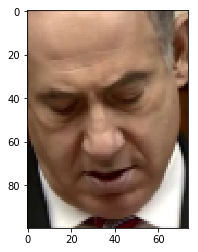

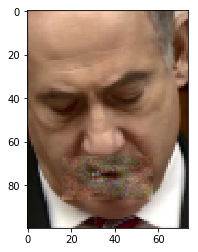

In [288]:
plot_stage(5)

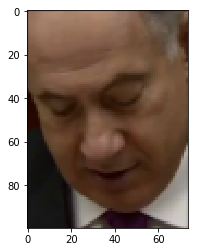

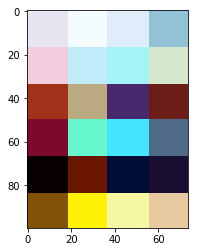

In [138]:
plot_stage(0)

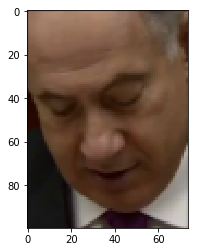

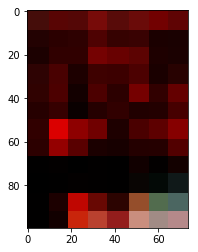

In [139]:
plot_stage(1)

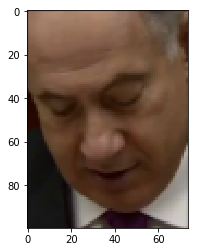

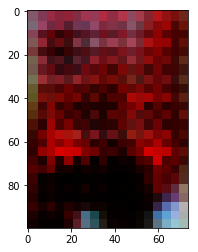

In [140]:
plot_stage(2)

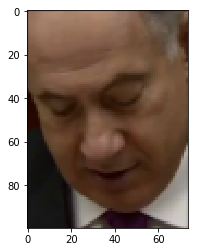

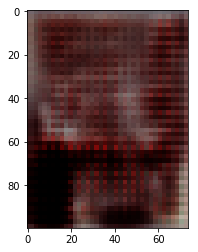

In [141]:
plot_stage(3)

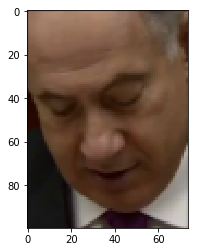

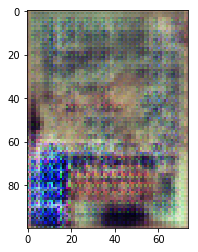

In [142]:
plot_stage(4)